In [1256]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from konlpy.tag import *
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss


import warnings
import urllib.request
warnings.filterwarnings('ignore')

MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1257]:
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
DATASET_NAME = "finance_data.csv"

In [1258]:
urllib.request.urlretrieve(DATASET_URL, 
                           filename = DATASET_NAME
                           )

('finance_data.csv', <http.client.HTTPMessage at 0x5310d2e00>)

In [1259]:
dataset = pd.read_csv(DATASET_NAME)
dataset.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [1260]:
news = pd.read_csv('./model/24.csv', index_col=0, lineterminator='\n')

In [1261]:
news

,stock_id,date_time,title,content


In [1262]:
news = news[['title', 'content', 'date_time']]
from datetime import datetime
news = news.dropna()

In [1263]:
news.notnull().sum()

title        0.0
content      0.0
date_time    0.0
dtype: float64

In [1264]:
del dataset['sentence']
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [1265]:
# 중복 데이터 확인
dataset[dataset['kor_sentence'].duplicated()]
news[news.duplicated()]

,title,content,date_time


In [1266]:
DATASET_PREP_FILE = './dataset_prep.csv'
# 중복 데이터 제거
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True)
news.drop_duplicates(inplace = True)
dataset.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장

Text(0, 0.5, 'Number')

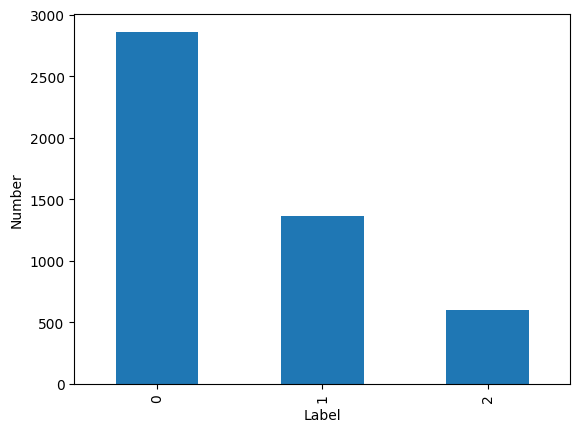

In [1267]:
dataset['labels'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

Text(0, 0.5, 'Ratio')

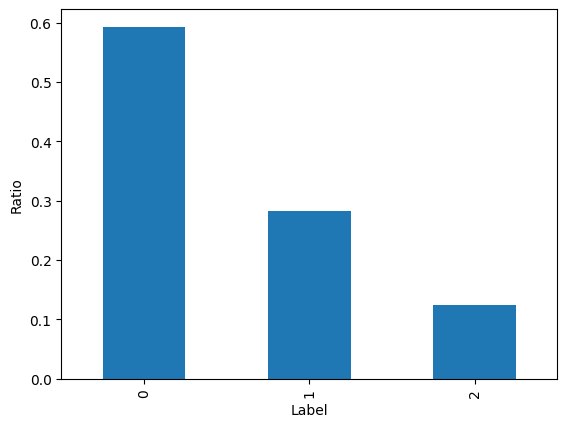

In [1268]:
dataset['labels'].value_counts(normalize = True).plot(kind = 'bar', )
plt.xlabel("Label")
plt.ylabel("Ratio")

In [1269]:
# 중립적인 기사문 59.27%, 긍정적인 기사문 28.22%, 부정적인 기사문 12.51%
dataset['labels'].value_counts(normalize = True)

labels
0    0.592708
1    0.282163
2    0.125129
Name: proportion, dtype: float64

In [1270]:
# 입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

In [1271]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_data)

In [1272]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 3861
테스트 입력 데이터 개수: 966


In [1273]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

labels
0    0.592852
1    0.282051
2    0.125097
Name: proportion, dtype: float64

In [1274]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

In [1275]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [1276]:
def conver_data(X_data):
    # BERT 입력으로 들어가는 token, mask, segment 저장용 리스트
    tokens, masks, segments = [], [], []
    
    for X in tqdm(X_data):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation=True, padding='max_length', max_length=MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0] * MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]


In [1277]:
X_train

307              총 영업 수익은 전년 동기 대비 27.6% 증가한 6100만 유로입니다.
3440                          노조와 회사 관계자들은 어제 전화를 받지 않았다.
1072    프로페셔널 및 소비자 애플리케이션에는 개인 내비게이션, 개인 안전, 현장 및 워크플...
2295                   전년도의 -0.4 mn에 비해 세후 이익은 0.1 mn이었다.
70      OMX 헬싱키 25 지수는 0.92pct 오른 2,518.67, 헬싱키 CAP 포트...
                              ...                        
560     2010년 8월 31일 16:25에 Basware 주식 거래소 릴리즈는 Baswar...
500      북해 원유 생산의 난제 중 하나는 송유관을 막고 생산을 중단할 수 있는 규모 형성이다.
862     (ADP News ) - 2008년 9월 30일 - 핀란드의 보안 및 개인 정보 소...
1589                    통합업무에 따른 보고는 2011년 1월 1일부터 시작됩니다.
1175    오디오 웹캐스트는 라이브로 제공되며 세르너 웹 사이트 www.cerner.com에 ...
Name: kor_sentence, Length: 3861, dtype: object

In [1278]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

0it [00:00, ?it/s]

3861it [00:00, 6338.21it/s]


In [1279]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

966it [00:00, 6663.04it/s]


In [1280]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [1281]:
bert_output = bert_outputs[0]

In [1282]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [1283]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS, 
                                          warmup_proportion = WARMUP_PROPORTION, 
                                          min_lr = MIN_LR, 
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [1284]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [1285]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_loss", 
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [1286]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)


In [1287]:
callbacks = [early_stopping, model_checkpoint]

In [1288]:
# EPOCHS = 100
# BATCH_SZIE = 32

# sentiment_model.fit(train_x, train_y, 
#                     epochs = EPOCHS, 
#                     shuffle = True, 
#                     batch_size = BATCH_SZIE, 
#                     validation_data = (test_x, test_y),
#                     callbacks = callbacks
#                     )

In [1289]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [1290]:
# X_data = [news]  # X_data를 리스트로 감싸서 전달
input_data = conver_data(news['content'])
predictions = sentiment_model_best.predict(input_data)
predicted_label = np.argmax(predictions, axis=1)

0it [00:00, ?it/s]


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
predicted_label

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       2, 1, 0, 1, 0, 1, 2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2,
       1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 2,
       2, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0,
       2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,

In [ ]:
array_list = predicted_label.tolist()

In [ ]:
import pandas as pd

data = {'datetime': news['date_time'], 'news':news['title'], 'label': array_list}

df = pd.DataFrame(data)
df.tail(40)

,datetime,news,label
858,2023-07-25 09:08:00,5000가구 브랜드 타운 중심 포레나 인천학익 내달 분양,0
859,2023-07-25 09:08:00,남부대학교아동시화공모전 개최,0
860,2023-07-25 09:08:00,프랑스는 중국 튀르키예는 사우디와 밀착 이념가치 실리 선회Global Economy,0
861,2023-07-25 09:08:00,원달러 환율 11원 오른 12810원 개장,1
862,2023-07-25 09:07:00,포토부스서 여름 파도 향기를 에이피알 포맨트 포토그레이와 팝업,0
863,2023-07-25 09:07:00,위메프 중소벤처기업부와 소상공인 미디어커머스 진출 돕는다,1
864,2023-07-25 09:07:00,저소득 위기가구 긴급복지지원 신청하세요,1
865,2023-07-25 09:06:00,스레드 등장에 위기 느꼈나틱톡도 텍스트 전용 기능 출시,0
866,2023-07-25 09:06:00,유니베라 보타니티 허다빈 프로 골프레슨 프로모션 열어,0
867,2023-07-25 09:06:00,책 한 모금땅은 알고 있다지구에서 벌어졌던 일들을,0


In [ ]:
df.to_csv('./24.csv')